In [9]:
import numpy as np
np.random.seed(42)
from tqdm import tqdm_notebook as tqdm


import torch
import sys
import pickle
import wandb
import os
from argparse import ArgumentParser
import torch.nn.functional as F
torch.cuda.is_available()

False

In [10]:
#sqrtL
dim = 2
lr = .5
a = np.asarray([14.7, 3.])#rmal(size=dim)
wt = torch.tensor( a, requires_grad=True, dtype=torch.float64, device="cpu")

In [11]:
#sqrtL
dim = 2
lr = .5
a = np.asarray([14.7, 3.])#rmal(size=dim)
wt = torch.tensor( a, requires_grad=True, dtype=torch.float64, device="cpu")

top_eig = []
ar = []
loss_ = [] 
stableness = []

num_epochs = 12
for epoch in range(num_epochs):
    ar += [wt.detach().clone().numpy()]
    Hessian = np.zeros((2, 2))
    Hessian[0, 0] = 2 * ar[-1][1]
    Hessian[0, 1] = Hessian[1, 0] = 4 * ar[-1][1] * ar[-1][0]
    Hessian[1, 1] = 2 * (1 + ar[-1][0] ** 2)
    
    svdvals = np.linalg.svd(Hessian, compute_uv=False)
    top_eig += [svdvals[0]]
    
    
    
    loss = (1. + wt[0] ** 2) * (wt[1] ** 2)
    train_loss =  loss ** 0.5
    loss_ += [train_loss.float().item()]
    train_loss.backward(retain_graph=True)
    
    Hessian = (2. * Hessian - np.tensordot(wt.grad.detach().numpy(), wt.grad.detach().numpy(), axes=0))/(4. * loss_[-1]) 
    svdvals = np.linalg.svd(Hessian, compute_uv=False)
    stableness += [lr * svdvals[0]]
    
    
    with torch.no_grad():
        wt -= lr * wt.grad
        #wt -= lr * wt.grad / ( (wt.grad[0] ** 2 + wt.grad[1] ** 2) ** 0.5 )
        wt.grad.zero_()
        
xaxis_sqrtL = np.array([x[0] for x in ar])
yaxis_sqrtL = np.array([x[1] for x in ar])




In [12]:
#ngd
dim = 2
lr = 5.
a = np.asarray([14.7, -3.])#rmal(size=dim)
wt = torch.tensor( a, requires_grad=True, dtype=torch.float64, device="cpu")

In [13]:

#ngd
dim = 2
lr = 5.
a = np.asarray([14.7, -3.])#rmal(size=dim)
wt = torch.tensor( a, requires_grad=True, dtype=torch.float64, device="cpu")


ar = []
top_eig = []
loss_ = [] 
stableness = []

num_epochs = 10
for epoch in range(num_epochs):
    ar += [wt.detach().clone().numpy()]
    Hessian = np.zeros((2, 2))
    Hessian[0, 0] = 2 * ar[-1][1]
    Hessian[0, 1] = Hessian[1, 0] = 4 * ar[-1][1] * ar[-1][0]
    Hessian[1, 1] = 2 * (1 + ar[-1][0] ** 2)
    
    svdvals = np.linalg.svd(Hessian, compute_uv=False)
    top_eig += [svdvals[0]]
    
    
    
    
    loss = (1. + wt[0] ** 2) * (wt[1] ** 2)
    train_loss =  loss #loss#loss ** 0.5
    loss_ += [loss.float().item()]
    train_loss.backward(retain_graph=True)
    

    with torch.no_grad():
        stableness += [ top_eig[-1] * lr / ( (wt.grad[0] ** 2 + wt.grad[1] ** 2) ** 0.5 ) ]
        wt -= lr * wt.grad / ( (wt.grad[0] ** 2 + wt.grad[1] ** 2) ** 0.5 )
        wt.grad.zero_()
        
        
        
xaxis_ngd = np.array([x[0] for x in ar])
yaxis_ngd = np.array([x[1] for x in ar])



In [14]:
def f(x, y):
    return ((1 + x ** 2) * (y ** 2)) ** 0.5

from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'
    

    def __init__(self, cmap, levels):
#         super(nlcmap, self).__init__(None,None)
        self.cmap = cmap
        self.N = self.cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels-self.levels.min()
        self._x/= self._x.max()
        self._y = np.linspace(0, 1, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

<ipython-input-15-ba5929d28712>:54: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
<ipython-input-15-ba5929d28712>:54: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


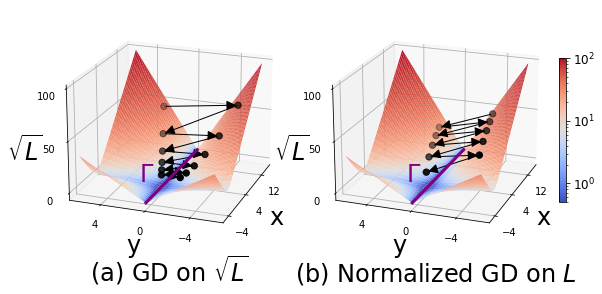

In [15]:
#sqrtl
import matplotlib
from matplotlib import pyplot as plt

from matplotlib.patches import FancyArrowPatch
import matplotlib.colors as colors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import proj3d


x = np.linspace(-6, 16, 30)
y = np.linspace(-6, 6, 400)
X, Y = np.meshgrid(x, y)#[x[0] for x in ar], [x[1] for x in ar])

Z = f(X, Y)
fig = plt.figure(figsize=plt.figaspect(0.5))


# ax = fig.gca(projection='3d',computed_zorder=False)
ax = fig.add_subplot(1, 2, 1, projection='3d',computed_zorder=False)
#box = ax.get_position()
#print (box.x0, box.x1)
#box.x0 = box.x0 + 0.1
#box.x1 = box.x1 + 0.1
#ax.set_position(box)

# plt.contourf(X, Y, Z, 20, cmap=plt.cm.coolwarm, levels = list(range(100)));
# ax.plot_surface(X, Y, Z, cmap=lambda x: plt.cm.coolwarm(np.log(x)));
# ax.contour(X, Y, Z, 12, linewidths=2, colors="k", linestyles="solid",)
ax.scatter3D(xaxis_sqrtL, yaxis_sqrtL, f(xaxis_sqrtL,yaxis_sqrtL), c='k', marker='o', s=40,zorder=10)
# ax.plot(xaxis, yaxis, f(xaxis,yaxis), '-',color='k')
# for i in range(len(xaxis)-1):
#     ax.quiver(
#         xaxis[i], yaxis[i], f(xaxis[i],yaxis[i]), # <-- starting point of vector
#         xaxis[i+1] - xaxis[i], yaxis[i+1] - yaxis[i], f(xaxis[i+1],yaxis[i+1]) -f(xaxis[i],yaxis[i]), # <-- directions of vector
#         color = 'k', alpha = 1, lw = 1, 
#     )


style="Simple,tail_width=0.5,head_width=4,head_length=8"
kw = dict(arrowstyle=style)




class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)
    

    
# ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,  alpha=1.,zorder =0)
log_cmap = nlcmap(plt.cm.coolwarm, 1.002** np.arange(2000))
# surf = ax.plot_surface(X, Y, Z, cmap=log_cmap, norm = colors.Normalize(vmin=0.,vmax=100),  alpha=1.,zorder =0)
# surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.coolwarm, norm = colors.Normalize(vmin=0.,vmax=100),  alpha=1.,zorder =0)
surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.coolwarm, norm = colors.LogNorm(vmin=0.5,vmax=100),  alpha=1.,zorder =0, rcount=100, ccount=100)


for i in range(len(xaxis_sqrtL)-1):
    ax.add_patch(Arrow3D([xaxis_sqrtL[i],xaxis_sqrtL[i+1]], [yaxis_sqrtL[i],yaxis_sqrtL[i+1]], [f(xaxis_sqrtL[i],yaxis_sqrtL[i]),f(xaxis_sqrtL[i+1],yaxis_sqrtL[i+1])], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k", connectionstyle="arc3,rad=0"),  )



zline = np.linspace(0, 0, 100)
xline = np.linspace(-6, 16, 100)
yline = np.linspace(0, 0, 100)
ax.plot3D(xline, yline, zline, 'purple',linewidth=3)

a= 'sffd'
ax.text(0., 2., 2., r'$\Gamma$', fontsize = 24, color = "purple")


ax.set_xlim(-6,16)

ax.set_xlabel('x', fontsize=24)
ax.set_ylabel('y', fontsize=24)
ax.set_zlabel(r'$\sqrt{L}$', fontsize=24, rotation = 0)
ax.set_title('(a) GD on ' + r'$\sqrt{L}$', fontsize=24, y=-0.15)

ax.view_init(20, 200)
ax.zaxis.set_rotate_label(False) 
ax.set_xticks([-4,4,12])
ax.set_yticks([-4,0,4],)
ax.set_zticks([0,50,100],)
#plt.tight_layout()
# fig.colorbar(  cm.ScalarMappable( cmap=log_cmap), ax=ax)
#cbar = fig.colorbar(  surf, ax=ax, fraction=0.028, pad=0.000)
#cbar.ax.tick_params(labelsize=12) 

#plt.tight_layout()
#plt.savefig('xy_contour_sqrtL.pdf', dpi=600)
#plt.show()



#ngd
#import matplotlib
#from matplotlib import pyplot as plt

#x = np.linspace(-6, 16, 30)
#y = np.linspace(-6, 6, 400)
#X, Y = np.meshgrid(x, y)#[x[0] for x in ar], [x[1] for x in ar])

#Z = f(X, Y)
#fig = plt.figure()
# ax = fig.gca(projection='3d',computed_zorder=False)
ax = fig.add_subplot(1, 2, 2, projection='3d',computed_zorder=False)
# plt.contourf(X, Y, Z, 20, cmap=plt.cm.coolwarm, levels = list(range(100)));
# ax.plot_surface(X, Y, Z, cmap=lambda x: plt.cm.coolwarm(np.log(x)));
# ax.contour(X, Y, Z, 12, linewidths=2, colors="k", linestyles="solid",)
ax.scatter3D(xaxis_ngd, yaxis_ngd, f(xaxis_ngd,yaxis_ngd), c='k', marker='o', s=40,zorder=10)
# ax.plot(xaxis, yaxis, f(xaxis,yaxis), '-',color='k')
# for i in range(len(xaxis)-1):
#     ax.quiver(
#         xaxis[i], yaxis[i], f(xaxis[i],yaxis[i]), # <-- starting point of vector
#         xaxis[i+1] - xaxis[i], yaxis[i+1] - yaxis[i], f(xaxis[i+1],yaxis[i+1]) -f(xaxis[i],yaxis[i]), # <-- directions of vector
#         color = 'k', alpha = 1, lw = 1, 
#     )


from matplotlib.patches import FancyArrowPatch
import matplotlib.colors as colors
import matplotlib.cm as cm

style="Simple,tail_width=0.5,head_width=4,head_length=8"
kw = dict(arrowstyle=style)



    
# ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,  alpha=1.,zorder =0)
log_cmap = nlcmap(plt.cm.coolwarm, 1.002** np.arange(2000))
# surf = ax.plot_surface(X, Y, Z, cmap=log_cmap, norm = colors.Normalize(vmin=0.,vmax=100),  alpha=1.,zorder =0)
# surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.coolwarm, norm = colors.Normalize(vmin=0.,vmax=100),  alpha=1.,zorder =0)
surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.coolwarm, norm = colors.LogNorm(vmin=0.5,vmax=100),  alpha=1.,zorder =0, rcount=100, ccount=100)


for i in range(len(xaxis_ngd)-1):
    ax.add_patch(Arrow3D([xaxis_ngd[i],xaxis_ngd[i+1]], [yaxis_ngd[i],yaxis_ngd[i+1]], [f(xaxis_ngd[i],yaxis_ngd[i]),f(xaxis_ngd[i+1],yaxis_ngd[i+1])], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k", connectionstyle="arc3,rad=0"),  )



zline = np.linspace(0, 0, 100)
xline = np.linspace(-6, 16, 100)
yline = np.linspace(0, 0, 100)
ax.plot3D(xline, yline, zline, 'purple',linewidth=3)

a= 'sffd'
ax.text(0., 2., 2., r'$\Gamma$', fontsize = 24, color = "purple")


ax.set_xlim(-6,16)

ax.set_xlabel('x', fontsize=24)
ax.set_ylabel('y', fontsize=24)
ax.set_title('(b) Normalized GD on ' + r'$L$', fontsize=24, y=-0.15)

ax.set_zlabel(r'$\sqrt{L}$', fontsize=24, rotation = 0)
ax.view_init(20, 200)
ax.zaxis.set_rotate_label(False) 
ax.set_xticks([-4,4,12])
ax.set_yticks([-4,0,4],)
ax.set_zticks([0,50,100],)
#plt.tight_layout()
# fig.colorbar(  cm.ScalarMappable( cmap=log_cmap), ax=ax)
cbar = fig.colorbar(  surf, ax=ax, fraction=0.028, pad=0.000)
cbar.ax.tick_params(labelsize=12) 

plt.tight_layout()
plt.savefig('xy_contour_ngd_sqrtL.pdf', dpi=600, bbox_inches="tight")
plt.show()


